In [1]:
import numpy as np 
import pandas as pd 
from keras.datasets.cifar10 import load_data 
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, Embedding, Concatenate
from matplotlib import pyplot as plt 
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones

In [2]:
(train_X, train_y), (test_X, test_y) = load_data()

In [3]:
def Discriminator(input_shape=(32, 32, 3), num_classes=10):
    input_label = Input(shape=(1,))
    il = Embedding(num_classes, 50)(input_label)
    n_nodes = input_shape[0] * input_shape[1]
    il = Dense(n_nodes)(il)
    il = Reshape((input_shape[0], input_shape[1], 1))(il)
    
    input_image = Input(shape=input_shape)
    merge = Concatenate()([input_image, il])
    
    final_input = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    final_input = LeakyReLU(alpha=0.2)(final_input)
    final_input = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(final_input)
    final_input = LeakyReLU(alpha=0.2)(final_input)
    final_input = Flatten()(final_input)
    final_input = Dropout(0.4)(final_input)
    out_layer = Dense(1, activation='sigmoid')(final_input)
    
    model = Model([input_image, input_label], out_layer)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model 

discriminator = Discriminator()
print(discriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      52224       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

In [4]:
def Generator(latent_dim, num_classes=10):
    input_label = Input(shape=(1,))
    il = Embedding(num_classes, 50)(input_label)
    n_nodes = 8 * 8
    il = Dense(n_nodes)(il)
    il = Reshape((8, 8, 1))(il)
    
    input_latent = Input(shape=(latent_dim,))
    
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes)(input_latent)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)
    merge = Concatenate()([gen, il])
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same')(gen)  # sigmoid - X / 255.0   tanh - X - 127.5 / 127.5 
    
    model = Model([input_latent, input_label], out_layer)
    return model 

generator = Generator(latent_dim=100, num_classes=10)
print(generator.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [5]:
def GAN(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output 
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan = GAN(generator, discriminator)
print(gan.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [6]:
def load_real_samples():
    (train_X, train_y), (_, _) = load_data()
    X = train_X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, train_y]

def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    idx = randint(0, images.shape[0], n_samples)
    X, labels = images[idx], labels[idx]
    y = ones((n_samples, 1))
    return [X, labels], y

def generate_latent_points(latent_dim, n_samples, num_classes=10):
    X_input = randn(latent_dim * n_samples)
    z_input = X_input.reshape(n_samples, latent_dim)
    labels = randint(0, num_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = zeros((n_samples, 1))
    return [images, labels_input], y

Epoch>1, Batch [50/390], d1=0.504, d2=0.741, g=0.692


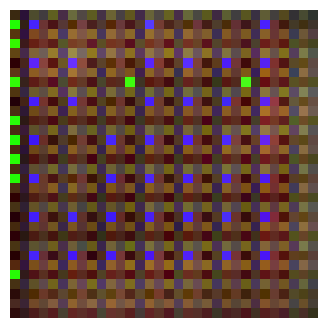

Epoch>1, Batch [100/390], d1=0.718, d2=0.710, g=0.723


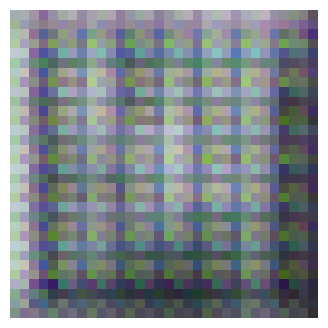

Epoch>1, Batch [150/390], d1=0.716, d2=0.660, g=0.770


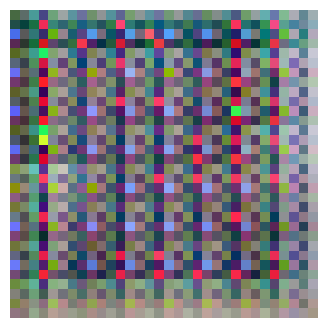

Epoch>1, Batch [200/390], d1=0.734, d2=0.669, g=0.758


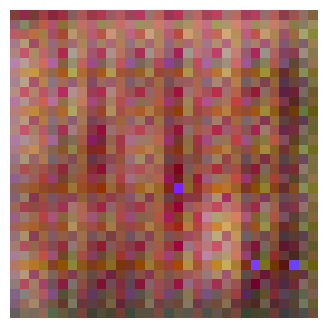

Epoch>1, Batch [250/390], d1=0.681, d2=0.756, g=0.651


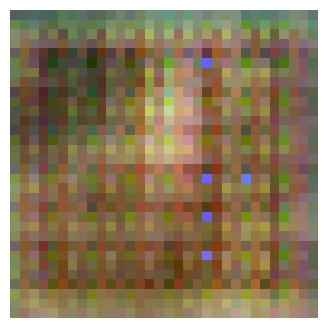

Epoch>1, Batch [300/390], d1=0.694, d2=0.684, g=0.723


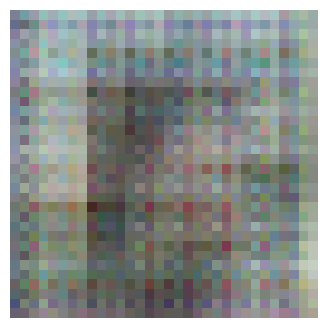

Epoch>1, Batch [350/390], d1=0.640, d2=0.774, g=0.653


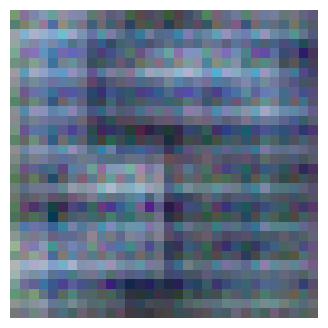

In [7]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            if (j + 1) % 50 == 0:
                print('Epoch>%d, Batch [%d/%d], d1=%.3f, d2=%.3f, g=%.3f' %(i + 1, j + 1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))
                plt.figure(figsize=(4, 4))
                plt.imshow(((X_fake[0] + 1) / 2.0 * 255).astype(np.uint8))
                plt.axis('off')
                plt.show()
    g_model.save('cifar_conditional_generator_model.h5')
    
d_model = Discriminator()
g_model = Generator(latent_dim=100)
gan_model = GAN(g_model, d_model)
dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=1)

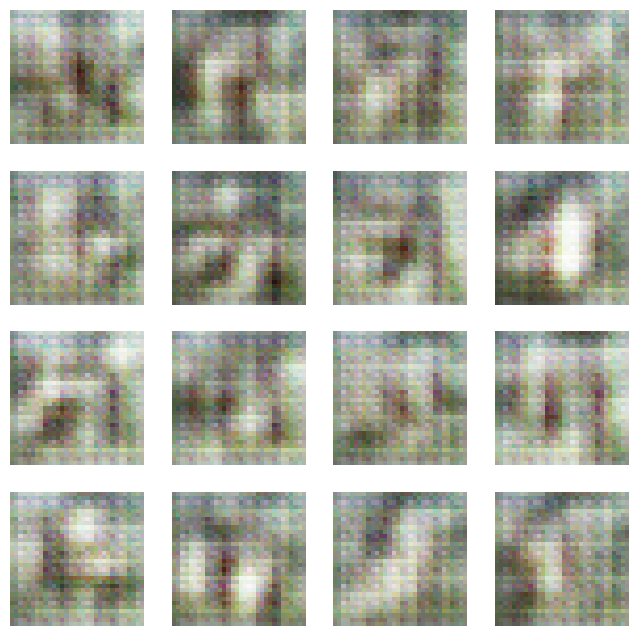

In [8]:
from keras.models import load_model

plt.figure(figsize=(8, 8))
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()
    
model = load_model('cifar_conditional_generator_model.h5', compile=False)
latent_points = generate_latent_points(100, 16)
X = ((model.predict(latent_points) + 1) / 2.0 * 255).astype(np.uint8)

show_plot(X, 4)